In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from numpy import split
from numpy import concatenate
from math import sqrt
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras import callbacks
from keras.utils import plot_model

In [2]:
# Load the new file
dataset = pd.read_csv('/content/drive/MyDrive/Final Air Pollution/Final_AP.csv')

The data starts from 01/03/2013 and ends on 28/02/2017.We will use the first three years of data for training predictive models and the final year for evaluating models. Hence, number of training days is 01/03/2013 - 29/02/2016, equals to 1096 days, i.e. 26304 hr. Number of test days is 01/03/2016 - 28/02/2017, 365 days, equals to 8760 hr.

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

# Split and scale the dataset into train/test sets

def Split_dataset(data):
    # Split into train_data (1096 days X 24 hr) and val_data (219 days X 24 hr), test_data (146 days X 24 hr )
    train_data, val_data, test_data = data[0:-8760], data[-8760:-3504], data[-3504:]

    # scale the data using min max scaling on training data
    train = scaler.fit_transform(train_data)
    val = scaler.transform(val_data)
    test = scaler.transform(test_data)

    # Restructure into windows of 24hrs
    train = np.array(np.split(train, len(train) / 24))
    val = np.array(np.split(val, len(val) / 24))
    test = np.array(np.split(test, len(test) / 24))

    return train, val, test


In [4]:
# Split into train and test
train, val, test = Split_dataset(dataset.values)

In [5]:
print(train.shape)
print(val.shape)
print(test.shape)

(1096, 24, 22)
(219, 24, 22)
(146, 24, 22)


We want to prepare the training data such that we iterate over the time steps and divide the data into overlapping windows; each iteration moves along 24 time steps (24hrs) and predicts the subsequent step (1hr).

*   Input Output
*   [h01, h02, h03, h04, . . . . , h21, h22, h23, h24], [h25]
*   [h02, h03, h04, h05, . . . . ,h22, h23, h24, h25], [h26]







In [6]:
# Convert series to supervised inputs and outputs

def to_supervised(train, n_input=24, n_out=1):
    # flatten data
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0

    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out

        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])

        # move along one time step
        in_start += 1

    return np.array(X), np.array(y)


Now let’s create a Baseline Metrics or else we may end up thinking our model works great when in fact it is doing worse than basic models. The simplest approach is to assume that predicted value is the last value of the sequence. This is called naive forecasting, and it is sometimes surprisingly difficult to outperform.

In [7]:
# Build the model

# Define parameters
n_epochs, n_batch = 200, 48

# Prepare training data
train_X, train_y = to_supervised(train, n_input=24)
val_X, val_y = to_supervised(val, n_input =24)

# Define the input parameters
tf.random.set_seed(7)
np.random.seed(7)
n_input, n_features, n_outputs = train_X.shape[1], train_X.shape[2], train_y.shape[1]

# Define the model
model = Sequential()
model.add(LSTM(200, return_sequences=False, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n_outputs))

# Compile the model
model.compile(loss = 'mse' , optimizer= Adam(learning_rate = 0.0005))

es_callback = callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4,
              patience=50, restore_best_weights=True)


In [8]:
print(train_X.shape, train_y.shape)

(26280, 24, 22) (26280, 1)


In [9]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               178400    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5

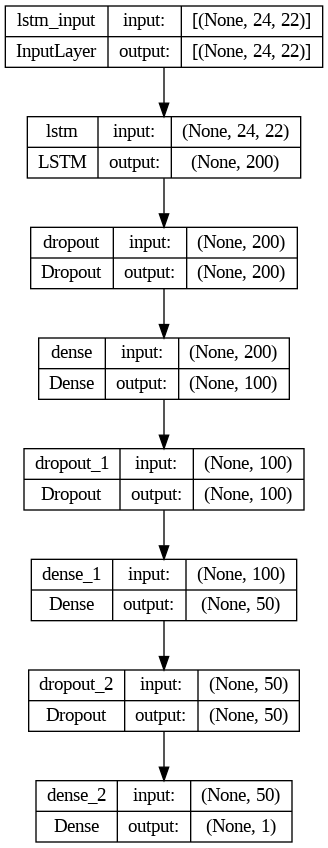

In [10]:
plot_model(model, to_file="LSTM_model.png", show_shapes=True, show_layer_names=True)

In [11]:
# Train the model
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=n_batch, verbose=1, validation_data = (val_X,val_y),callbacks=[es_callback])

Epoch 1/200
548/548 [==============================] - 33s 58ms/step - loss: 0.0016 - val_loss: 5.6768e-04
Epoch 2/200
548/548 [==============================] - 32s 58ms/step - loss: 8.4391e-04 - val_loss: 4.3679e-04
Epoch 3/200
548/548 [==============================] - 32s 58ms/step - loss: 7.2159e-04 - val_loss: 3.9429e-04
Epoch 4/200
548/548 [==============================] - 32s 58ms/step - loss: 6.2523e-04 - val_loss: 3.5449e-04
Epoch 5/200
548/548 [==============================] - 31s 56ms/step - loss: 5.8259e-04 - val_loss: 3.3226e-04
Epoch 6/200
548/548 [==============================] - 31s 56ms/step - loss: 5.5482e-04 - val_loss: 3.5542e-04
Epoch 7/200
548/548 [==============================] - 32s 58ms/step - loss: 5.4170e-04 - val_loss: 2.8261e-04
Epoch 8/200
548/548 [==============================] - 31s 57ms/step - loss: 5.1619e-04 - val_loss: 2.5312e-04
Epoch 9/200
548/548 [==============================] - 31s 57ms/step - loss: 4.9840e-04 - val_loss: 3.0797e-04
Epoch

In [12]:
np.save("history_LSTM48.npy", history.history)
model.save('LSTM48.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


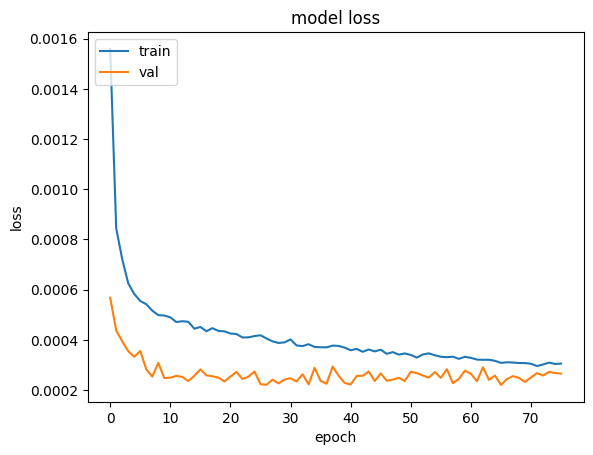

In [13]:
plt.plot(history.history['loss'], label='train')  # plotting train loss
plt.plot(history.history['val_loss'], label='val')  # plotting validation loss

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
# shape input for model
test_X, test_y = to_supervised(test, n_input =24)

# make forecast
yhat = model.predict(test_X)

# actual observation
test_y = test_y.reshape(-1,1)

# reshape input for inverse transform
input_X = test_X.reshape((test_X.shape[0], test_X.shape[1]*test_X.shape[2]))

# invert scaling for actual
inv_test_y = concatenate((test_y, input_X[:, -21:]), axis=1)
inv_test_y = scaler.inverse_transform(inv_test_y)
inv_test_y= inv_test_y[:, 0]

# invert scaling for predictions
inv_yhat = concatenate((yhat, input_X[:, -21:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# estimate prediction error
rmse = sqrt(mean_squared_error(inv_test_y,inv_yhat))
print('LSTM Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(inv_test_y, inv_yhat)
print('Test MAE: %.3f' % mae)

R2=r2_score(inv_test_y, inv_yhat)
print('Test R2: %.3f' % R2)

109/109 [==============================] - 2s 15ms/step
LSTM Test RMSE: 18.090
Test MAE: 10.449
Test R2: 0.971
